In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

In [15]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [16]:
df_train2= df_train.copy().drop(['Transported'],axis=1)

df_train2.shape


(8693, 13)

In [17]:
data = pd.concat([df_train2, df_test], axis = 0).reset_index(drop = True)

data.shape

(12970, 13)

In [18]:
# Data from the Cabin
data[["CabinDeck", "CabinNo.", "CabinSide"]] = data["Cabin"].str.split('/', expand = True)

In [19]:
data["Group"] = data["PassengerId"].str.split('_', expand = True)[0]

In [20]:
No_People_In_PassengerGroup = data.groupby('Group').aggregate({'PassengerId': 'size'}).reset_index()
No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "Group_size"})

data = data.merge(No_People_In_PassengerGroup[["Group", "Group_size"]], how = 'left', on = ['Group'])


In [21]:
# Data from the group
No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["Group_size"].apply(lambda x: False if x > 1 else True)
data = data.merge(No_People_In_PassengerGroup[["Group", "IsAlone"]], how = 'left', on = ['Group'])

In [22]:
# Filling NaNs based on Age
def fill_nans_by_age_and_cryosleep(df):
    df["RoomService"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["Spa"])
    df["VRDeck"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["VRDeck"])

    return df

data = fill_nans_by_age_and_cryosleep(data)


In [10]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,PassengerGroup,NoInPassengerGroup,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,1,True


In [43]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
HomePlanet      288
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
Group_size        0
PassengerId       0
Group             0
IsAlone           0
dtype: int64

In [89]:
data2 = data.copy()

In [92]:
GHP_gb = data2.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb

HomePlanet,Earth,Europa,Mars
Group,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0
0004,1.0,0.0,0.0
0005,1.0,0.0,0.0
...,...,...,...
9276,0.0,1.0,0.0
9277,1.0,0.0,0.0
9278,1.0,0.0,0.0


In [93]:
((GHP_gb>0).sum(axis=1)>1).value_counts()

# Each Group is from the same planet


False    9124
dtype: int64

In [94]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,IsAlone
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,Colatz Keen,E,3,S,0064,2,False
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,A,0,P,0119,2,False
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,Arraid Inicont,D,6,P,0210,1,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,F,46,S,0242,1,True
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,C,11,S,0251,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,0.0,0.0,Vanley Simmonders,E,552,P,8621,1,True
12673,8678_01,NaN,True,G/1399/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Eilan Kellson,G,1399,S,8678,2,False
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,Raston Maltorted,D,275,P,8775,1,True
12852,9025_01,NaN,False,G/1454/S,TRAPPIST-1e,42.0,False,0.0,0.0,28.0,726.0,0.0,Ale Whitersone,G,1454,S,9025,2,False


In [103]:

GHP_index=data2[data2['HomePlanet'].isna()][(data2[data2['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
GHP_index

Int64Index([   59,   113,   405,   407,   438,   471,   501,   505,   524,
              568,
            ...
            11682, 11876, 12124, 12149, 12158, 12250, 12590, 12673, 12852,
            12906],
           dtype='int64', length=131)

In [104]:
data2.loc[GHP_index,'HomePlanet']=data2.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

In [105]:
data2[data2['HomePlanet'].isna()][data2['IsAlone']==False]

<ipython-input-105-47bd5143383b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2[data2['HomePlanet'].isna()][data2['IsAlone']==False]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,IsAlone
6917,7336_01,NaN,False,F/1411/S,TRAPPIST-1e,30.0,False,2.0,0.0,5.0,1.0,962.0,Dianie Lambles,F,1411,S,7336,2,False
6918,7336_02,NaN,False,F/1411/S,TRAPPIST-1e,26.0,False,0.0,0.0,902.0,0.0,0.0,Tanley Leodger,F,1411,S,7336,2,False


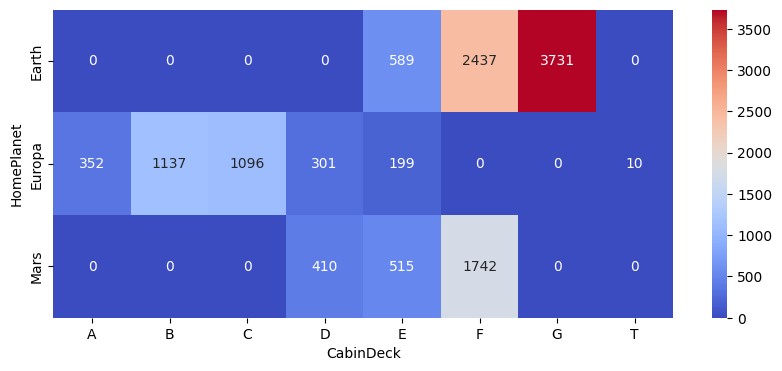

In [106]:
# Distribution of CabinDeck and HomePlanet
CDHP_gb =data2.groupby(['CabinDeck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

In [107]:
# Decks A, B, C or T came from Europa
data2.loc[(data2['HomePlanet'].isna()) & (data2['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data2.loc[(data2['HomePlanet'].isna()) & (data2['CabinDeck']=='G'), 'HomePlanet']='Earth'

In [108]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,IsAlone
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,Arraid Inicont,D,6,P,0210,1,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,F,46,S,0242,1,True
291,0321_01,NaN,False,F/61/S,TRAPPIST-1e,59.0,True,1018.0,0.0,209.0,0.0,0.0,Quites Bache,F,61,S,0321,1,True
365,0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,Teron Sageng,D,15,S,0402,1,True
481,0518_01,NaN,True,F/92/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,Soyos Parta,F,92,S,0518,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12347,7961_01,NaN,False,D/231/S,TRAPPIST-1e,39.0,False,1905.0,0.0,479.0,0.0,0.0,Quants Burle,D,231,S,7961,1,True
12542,8417_01,NaN,False,F/1617/S,TRAPPIST-1e,43.0,False,0.0,0.0,775.0,0.0,93.0,Luzel Bertsontry,F,1617,S,8417,1,True
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,1216.0,NaN,F,1730,P,8435,1,True
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,0.0,0.0,Vanley Simmonders,E,552,P,8621,1,True


In [110]:
data2.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet       94
Group_size        0
PassengerId       0
Group             0
IsAlone           0
dtype: int64

## Correr desde aqui para Cryo Data

In [118]:
cryo_data = data2.copy()

In [119]:
cryo_data = cryo_data.drop(['CabinNo.', 'Group', 'Name', 'Cabin', 'PassengerId'],axis =1)

In [120]:
cryo_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,IsAlone
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,1,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,1,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,2,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,2,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,1,True


In [121]:
missing_categorical_columns = cryo_data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)
missing_categorical_columns.remove('CryoSleep')
missing_categorical_columns

['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [122]:
for col in missing_categorical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mode()[0])

In [123]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet        0
Destination       0
VIP               0
CabinDeck         0
CabinSide         0
Group_size        0
IsAlone           0
dtype: int64

In [124]:
missing_numerical_columns = cryo_data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mean())

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [125]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
HomePlanet        0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
CabinDeck         0
CabinSide         0
Group_size        0
IsAlone           0
dtype: int64

In [126]:
null_cryo = cryo_data[cryo_data['CryoSleep'].isnull()]

In [127]:
has_cryo = cryo_data[cryo_data['CryoSleep'].notnull()]

In [128]:
has_cryo.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
CabinDeck       0
CabinSide       0
Group_size      0
IsAlone         0
dtype: int64

In [162]:
has_cryo = has_cryo.dropna()

In [163]:
has_cryo.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
CabinDeck       0
CabinSide       0
Group_size      0
IsAlone         0
dtype: int64

In [130]:
# Separate the target and the features variables
y = has_cryo["CryoSleep"]
X = has_cryo.drop(columns="CryoSleep")


In [131]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group_size'],
      dtype='object')
Index(['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide',
       'IsAlone'],
      dtype='object')


In [132]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [134]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [135]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.709991,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.011691
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.016645,2.217769,-0.281844,0.124948,-0.137953,-0.259010,-0.644878
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.228313,-0.346252,-0.138465,-0.298044,0.151414,-0.259010,-0.644878
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.465033,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.336135,0.785973,-0.102774,0.228075,-0.278554,-0.259010,-0.011691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10123,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-0.124467,0.368109,-0.283074,-0.165204,-0.276740,0.485553,-0.644878
10124,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,2.062772,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,0.621496
10125,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.933874,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878
10126,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.000556,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878


In [136]:
X_train.shape

(10128, 27)

In [137]:
y_train

6518     False
8784     False
4654     False
8319     False
5899     False
         ...  
11164    False
591       True
5992      True
2496      True
7374      True
Name: CryoSleep, Length: 10128, dtype: object

In [138]:
y_train = y_train.astype(int)
y_train

6518     0
8784     0
4654     0
8319     0
5899     0
        ..
11164    0
591      1
5992     1
2496     1
7374     1
Name: CryoSleep, Length: 10128, dtype: int64

In [139]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=60, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1680      
                                                                 
 dense_1 (Dense)             (None, 50)                3050      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6811 (26.61 KB)
Trainable params: 6811 (26.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

Epoch 1/100
317/317 [==============================] - 4s 5ms/step - loss: 0.2357 - accuracy: 0.8975
Epoch 2/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1265 - accuracy: 0.9404
Epoch 3/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1199 - accuracy: 0.9442
Epoch 4/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1134 - accuracy: 0.9475
Epoch 5/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1142 - accuracy: 0.9471
Epoch 6/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1111 - accuracy: 0.9448
Epoch 7/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1081 - accuracy: 0.9460
Epoch 8/100
317/317 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9447
Epoch 9/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1072 - accuracy: 0.9457
Epoch 10/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1056 - accura

In [141]:
y_test = y_test.astype(int)
y_test

2965     0
11871    0
12312    1
8606     0
4093     0
        ..
11380    0
10044    0
5830     1
601      1
9901     1
Name: CryoSleep, Length: 2532, dtype: int64

In [142]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

80/80 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9491
Test accuracy: 0.9490521550178528, Test loss: 0.10857503116130829


In [143]:
null_cryo.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,IsAlone
92,Earth,NaN,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.000000,G,P,2,False
98,Earth,NaN,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.000000,F,P,1,True
104,Europa,NaN,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.000000,B,P,4,False
111,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,303.965679,F,P,1,True
152,Earth,NaN,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.000000,E,S,1,True


In [144]:
X_pred = null_cryo.drop(columns="CryoSleep")
X_pred

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,IsAlone
92,Earth,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,2,False
98,Earth,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,1,True
104,Europa,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,4,False
111,Mars,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,1,True
152,Earth,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,1,True
12801,Europa,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,6,False
12902,Europa,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,1,True
12923,Earth,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,1,True


In [145]:
X_pred = preprocessor.transform(X_pred)

In [146]:
pd.DataFrame(X_pred)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.888369,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.011691
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.124467,-0.346252,-0.283074,0.698260,-0.276740,-0.148548,-0.644878
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.792762,-0.346252,-0.079391,-0.298044,-0.278554,1.163502,1.254683
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.195023,-0.346252,-0.283074,-0.298044,-0.278554,-0.002700,-0.644878
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.062772,-0.346252,0.323053,-0.298044,-0.274019,-0.259010,-0.644878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.618360,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878
306,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.124467,-0.346252,1.059636,-0.285809,2.063592,-0.242989,2.521056
307,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.863318,-0.346252,0.946411,-0.298044,0.649415,0.472062,-0.644878
308,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-1.041696,-0.346252,-0.283074,0.004261,0.970530,-0.234557,-0.644878


In [147]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

10/10 [==============================] - 0s 2ms/step


In [150]:
pred_df = pd.DataFrame(predictions)

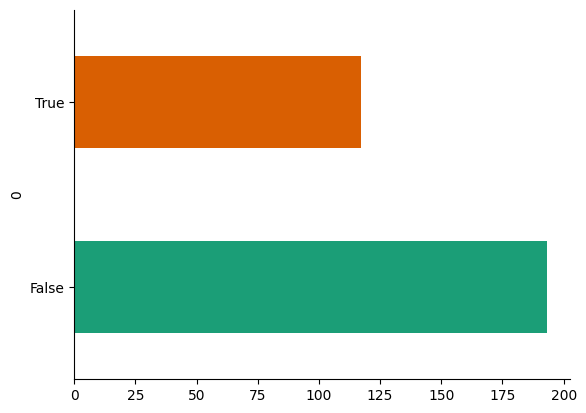

In [151]:
from matplotlib import pyplot as plt
import seaborn as sns
pred_df.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [152]:
null_cryo['CryoSleep'] = predictions
null_cryo

<ipython-input-152-6acac6c52771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_cryo['CryoSleep'] = predictions


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,IsAlone
92,Earth,False,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,2,False
98,Earth,False,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,1,True
104,Europa,False,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,4,False
111,Mars,True,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,1,True
152,Earth,False,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,True,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,1,True
12801,Europa,False,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,6,False
12902,Europa,False,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,1,True
12923,Earth,False,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,1,True


In [153]:
data2.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet       94
Group_size        0
PassengerId       0
Group             0
IsAlone           0
dtype: int64

In [154]:
datam = data2.copy()

In [155]:
datam['CryoSleep'] = datam['CryoSleep'].fillna(null_cryo['CryoSleep'])




In [156]:
datam.isnull().sum().sort_values(ascending=False)

Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet       94
Group             0
Group_size        0
PassengerId       0
CryoSleep         0
IsAlone           0
dtype: int64

In [ ]:
datam.iloc[92:111]['CryoSleep']

In [159]:
data2.iloc[92:111]['CryoSleep']

92       NaN
93      True
94     False
95     False
96      True
97      True
98       NaN
99     False
100     True
101    False
102    False
103    False
104      NaN
105    False
106     True
107     True
108    False
109    False
110    False
Name: CryoSleep, dtype: object

In [160]:
datam = fill_nans_by_age_and_cryosleep(datam)

In [161]:
datam.isnull().sum().sort_values(ascending=False)

Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
Destination     274
Age             270
FoodCourt       171
Spa             164
RoomService     162
ShoppingMall    161
VRDeck          149
HomePlanet       94
Group             0
Group_size        0
PassengerId       0
CryoSleep         0
IsAlone           0
dtype: int64

In [164]:
datam.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,1,True


In [ ]:
datam.to_csv('updated.csv')